In [95]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./data/',one_hot = True)
print(len(mnist.train.labels))

!pip install -U tensorboardcolab
from tensorboardcolab import *
import shutil

shutil.rmtree('./logs/', ignore_errors=True)
os.mkdir('./logs/')

tf.reset_default_graph()
tbc=TensorBoardColab()

Extracting ./data/train-images-idx3-ubyte.gz
Extracting ./data/train-labels-idx1-ubyte.gz
Extracting ./data/t10k-images-idx3-ubyte.gz
Extracting ./data/t10k-labels-idx1-ubyte.gz
55000
Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python3.6/dist-packages (0.0.19)
Wait for 8 seconds...
TensorBoard link:
http://802cad52.ngrok.io


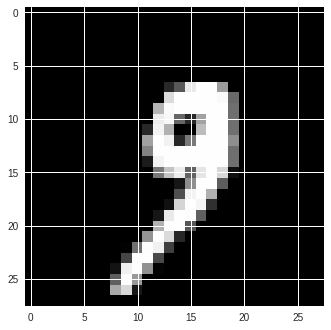

In [96]:
import matplotlib.pyplot as plt 
import numpy as np
def show_image(im):
  two_d = np.array(im, dtype='float')
  pixels = two_d.reshape((28, 28))
  plt.imshow(pixels,cmap='gray')
show_image(mnist.test.images[1000])

In [0]:
#convolutional model

def cnn(x,weights,biases,dropout):
    x = tf.reshape(x, shape=[-1,28,28,1])  #[batch_size,height,width,number_of_channels]
    
    #layer1
    conv1 = conv2d(x,weights['w1'],biases['b1'])
    conv1_conv_dims = conv1.get_shape().as_list()
    print("conv1 conv utput dimensions {}".format(conv1_conv_dims))
    conv1 = maxpool(conv1,k=2)
    conv1_maxpool_dims = conv1.get_shape().as_list()
    print("conv1 maxpool output dimensions {}".format(conv1_maxpool_dims))
    
    #layer2
    conv2 = conv2d(conv1,weights['w2'],biases['b2'])
    conv2_conv_dims = conv2.get_shape().as_list()
    print("conv2 conv output dimensions {}".format(conv2_conv_dims))
    conv2 = maxpool(conv2,k=2)
    conv2_maxpool_dims = conv2.get_shape().as_list()
    print("conv2 maxpool output dimensions {}".format(conv2_maxpool_dims))
    
    #fully connected layer
    fc1 = tf.reshape(conv2, [-1, weights['w3'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['w3']), biases['b3'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout) #dropout
    
    #output layer
    output = tf.add(tf.matmul(fc1, weights['w4']), biases['b4'])
    
    return output
    
def conv2d(x,weight,bias,strides=1):
    x = tf.nn.conv2d(x,weight,strides = [1,strides,strides,1],padding="SAME")  #strides = [batch_size,height,width,number_of_channels]
    x = tf.nn.bias_add(x,bias)
    x = tf.nn.relu(x)
    return x
    
def maxpool(x,k=2):
  return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],padding='SAME')
    


In [0]:
#training parameters
learning_rate = 0.001
batch_size = 128
dropout = 0.5
epochs = 256

#inputs outputs 
num_inputs = 784
num_outputs = 10

#log path
log_path = './logs/'

#graph structure
X = tf.placeholder(tf.float32,[None,num_inputs],name = "inputs")
Y= tf.placeholder(tf.float32,[None,num_outputs],name= "outputs")
keep_prob = tf.placeholder(tf.float32,name = "dropout")


In [0]:
#weights
weights = {
    'w1' : tf.Variable(tf.random_normal([5, 5, 1, 16])), #5x5 conv, 1 channel, 16 filters
    'w2' : tf.Variable(tf.random_normal([3, 3, 16, 32])), #3x3 conv, 16 channel, 32 filters
    'w3' : tf.Variable(tf.random_normal([7*7*32, 256])), #fully connected 128 inputs, 64 outputs
    'w4' : tf.Variable(tf.random_normal([256, num_outputs]))
}

#biases
biases = {
    'b1' : tf.Variable(tf.random_normal([16])),
    'b2' : tf.Variable(tf.random_normal([32])),
    'b3' : tf.Variable(tf.random_normal([256])),
    'b4' : tf.Variable(tf.random_normal([num_outputs]))
}

In [100]:
#model construction
logits  = cnn(X,weights,biases,keep_prob)
with tf.name_scope('ACTIVATIONS'):
  predictions = tf.nn.softmax(logits)

with tf.name_scope('LOSS'):
  #cross entropy
  loss= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))

with tf.name_scope('OPTIMIZER'):  
  optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

  
with tf.name_scope('ACCURACY'):
  accuracy = tf.equal(tf.argmax(predictions, 1), tf.argmax(Y, 1))
  accuracy = tf.reduce_mean(tf.cast(accuracy, tf.float32))
  
#summary
tf.summary.scalar("LOSS", loss)
tf.summary.scalar("ACCURACY", accuracy)
tf.summary.histogram("HISTOGRAM", predictions)
summary_op = tf.summary.merge_all()

#variables initialization
init = tf.global_variables_initializer()

conv1 conv utput dimensions [None, 28, 28, 16]
conv1 maxpool output dimensions [None, 14, 14, 16]
conv2 conv output dimensions [None, 14, 14, 32]
conv2 maxpool output dimensions [None, 7, 7, 32]


In [101]:
#training
with tf.Session() as sess:
  sess.run(init)
  #summ_writer = tf.summary.FileWriter(log_path, graph=tf.get_default_graph())
  train_writer = tbc.get_writer();
  for epoch in range(epochs):
    no_of_batches = int(mnist.train.num_examples/batch_size)
    for curr_batch in range(no_of_batches):
      x,y = mnist.train.next_batch(batch_size)
      _,summ=sess.run([optimizer,summary_op],feed_dict={X:x,Y:y,keep_prob:0.7})
      #summ_writer.add_summary(summ)
      train_writer.add_summary(summ,epoch*no_of_batches+curr_batch)
           
    acc=sess.run(accuracy,feed_dict={X:mnist.train.images,Y:mnist.train.labels,keep_prob:1.0})
    print("epoch {0} training accuracy {1}".format(epoch,acc))
     
  #testing
  print("testing accuracy",sess.run(accuracy,feed_dict={X:mnist.test.images,Y:mnist.test.labels,keep_prob:1.0}))
train_writer.add_graph(sess.graph)
sess.close()
train_writer.flush();
tbc.close()
    
    

epoch 0 training accuracy 0.8628000020980835
epoch 1 training accuracy 0.8571272492408752
epoch 2 training accuracy 0.6459090709686279
epoch 3 training accuracy 0.33796364068984985
epoch 4 training accuracy 0.27643635869026184
epoch 5 training accuracy 0.26998183131217957
epoch 6 training accuracy 0.27327272295951843
epoch 7 training accuracy 0.2645818293094635
epoch 8 training accuracy 0.270181804895401
epoch 9 training accuracy 0.3059999942779541
epoch 10 training accuracy 0.3195818066596985
epoch 11 training accuracy 0.3075818121433258
epoch 12 training accuracy 0.3521272838115692
epoch 13 training accuracy 0.3500909209251404
epoch 14 training accuracy 0.3808363676071167
epoch 15 training accuracy 0.4378545582294464
epoch 16 training accuracy 0.440854549407959
epoch 17 training accuracy 0.45183637738227844
epoch 18 training accuracy 0.49001818895339966
epoch 19 training accuracy 0.5350182056427002
epoch 20 training accuracy 0.4896363615989685
epoch 21 training accuracy 0.51956361532

In [0]:
#training accuracy - 99.17
#testing accuracy - 97.98
#tensorboard link-http://802cad52.ngrok.io